In [48]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot
import sklearn.linear_model
import matplotlib.pyplot as plt
import pyreadstat
import datetime
import FG_Methods
import tabulate
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

In [2]:
# Initialise Values

df_path = "C:\\Users\\fabio\\OneDrive\\Documents\\Studies\\Social_Research\\data\\ZA7780_v1-0-0.dta"
df = pd.read_stata(df_path, convert_categoricals=False)
df.info()

unique_country_codes = set(df["isocntry"].values)
unique_country_codes = sorted(unique_country_codes)
print(unique_country_codes)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38718 entries, 0 to 38717
Columns: 479 entries, studyno1 to w87
dtypes: float64(284), int16(5), int32(3), int8(184), object(3)
memory usage: 92.7+ MB
['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CY-TCC', 'CZ', 'DE-E', 'DE-W', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'RS-KM', 'SE', 'SI', 'SK', 'TR']


In [3]:
#Output Dataframe as csv

"""project_folder = "C:\\Users\\fabio\\OneDrive\\Documents\\Studies\\Social_Research\\"

df_column_headers = ""
for i in df.columns:
    if i == df.columns[0]:
        df_column_headers = i
    else:
        df_column_headers = df_column_headers + ", " + i

np.savetxt(project_folder + 'social_research_dataframe.csv',  np.asarray(df), header=df_column_headers, delimiter=',', fmt='%s')"""


'project_folder = "C:\\Users\\fabio\\OneDrive\\Documents\\Studies\\Social_Research\\"\n\ndf_column_headers = ""\nfor i in df.columns:\n    if i == df.columns[0]:\n        df_column_headers = i\n    else:\n        df_column_headers = df_column_headers + ", " + i\n\nnp.savetxt(project_folder + \'social_research_dataframe.csv\',  np.asarray(df), header=df_column_headers, delimiter=\',\', fmt=\'%s\')'

In [31]:
"""Note this is currently unweighted"""
"""This is the old version of the data, since I decide to go for a dictionary approach"""

def fg_counter(counter_value, total_iterations_qty, start, number_of_updates_required_for_total_run = 10, update_counter = False):
    if float(counter_value) % int(total_iterations_qty / number_of_updates_required_for_total_run) == 0:
        print("-----")
        print(datetime.now())
        PC = float(float(counter_value) / total_iterations_qty)
        print(str(counter_value) + " / " + str(total_iterations_qty))
        print(PC)
        print("end estimate @: " + str((datetime.now() - start) * (total_iterations_qty / counter_value) + datetime.now()))
        if update_counter == True:
            return PC    

def transfer_columns(new_df, original_df, target_string, target_string_at_start=True, data_columns_exact_match=False):
    #this method scans every column header of original_df and if target_string is contained within a header, at column is added to new df.
    #this allows me to iterativelly add groups of columns from the original datarame to the reduced datafrom for the analysis
    #target string must be entered as a string
    columns_original = original_df.columns
    columns_new = new_df.columns
    if type(target_string) is str:
        target_string = [target_string]
    
    for string_ in target_string:
        for col in columns_original:
            if col.find(string_) >= 0 and not col in new_df and target_string_at_start==False: #FG_Note: test this additional boolean
                new_df = pd.concat([new_df, original_df[col]], axis=1)
            if col.find(string_) == 0 and not col in new_df and target_string_at_start==True:
                new_df = pd.concat([new_df, original_df[col]], axis=1)
        
    return new_df

def return_stats_on_group(original_df, group_column, group_identifiers, data_group, data_columns_exact_match=False):

    group_flag = []
    group_flag = np.array(original_df[group_column] == group_identifiers[0])

    for i in range(1, len(group_identifiers)):
        group_flag_ = np.array(original_df[group_column] == group_identifiers[i])
        group_flag = group_flag | group_flag_
    results_df = original_df[group_flag]
    
    results_df = results_df.drop(group_column, axis=1) 
    columns = results_df.columns
    for col in columns:
            if col.find(data_group[0]) == -1:
                results_df = results_df.drop(col, axis=1)
    


    #print(type(float("{:.2f}".format(results_df.values.mean()))))
    
    return float("{:.2f}".format((5-results_df.values.mean()))), float("{:.2f}".format(results_df.values.std()))
    #return results_df.values.mean(), results_df.values.std()

def run_study(unit_request_list, unit_column, unit_type, data_request_list):
    df_results = pd.DataFrame()
    df_reduced = pd.DataFrame()
    df_reduced = transfer_columns(df_reduced, df, [unit_column], target_string_at_start=True, data_columns_exact_match=False)    
    for data_request in data_request_list:
        df_reduced = transfer_columns(df_reduced, df, data_request["data_group"], target_string_at_start=True, data_columns_exact_match=False)    

    for unit_request in unit_request_list:
        result_series_2 = pd.Series()
        for data_request in data_request_list:
            output_mean, output_std = return_stats_on_group(df_reduced, unit_column, unit_request["unit_group"], data_request["data_group"], data_columns_exact_match=False)

            #enter data to series
            result_dict = {(data_request["data_group_name"], "mean"): output_mean, (data_request["data_group_name"], "std"): output_std}
            result_series = pd.Series(result_dict, name=unit_request["unit_name"])
            df_results = df_results.append(result_series)

    df_results[unit_type] = df_results.index
    df_results = df_results.groupby(unit_type).mean()
    return df_results


#With the key being: Country, Value Name, Value

#create data request
unit_request_list = [{"unit_group" : ["GB"], "unit_name": "UK"},
                     {"unit_group" : ["IT", "ES", "PT", "GR", "MT", "CY", "CY-TCC"], "unit_name": "Southern Euro"},
                     {"unit_group" : ["LV"], "unit_name": "Latvia"},
                     {"unit_group" : ["RO"], "unit_name": "Romania"}]
unit_column = "isocntry"
unit_type = "country"
data_request_list = [{"data_group": ["qa1a_"], "data_group_name": "qa1a"},
                     {"data_group": ["qa2a_"], "data_group_name": "qa2a"}]

df_results = run_study(unit_request_list, unit_column, unit_type, data_request_list)


print("qa1a - How would you judge the current situation in each of the following?")
print("qa2a - What are your expectations for the next twelve months")
df_results.head()
#print()



qa1a - How would you judge the current situation in each of the following?
qa2a - What are your expectations for the next twelve months


qa1a        qa2a      
               mean   std  mean   std
country                              
Latvia         2.33  0.73  2.83  0.80
Romania        2.13  0.99  2.76  0.87
Southern Euro  2.07  0.89  2.80  0.89
UK             2.38  0.83  3.12  0.88

0.0011013507431178252


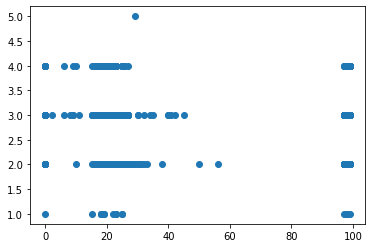

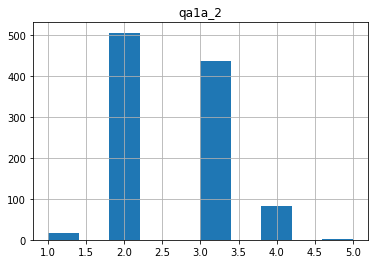

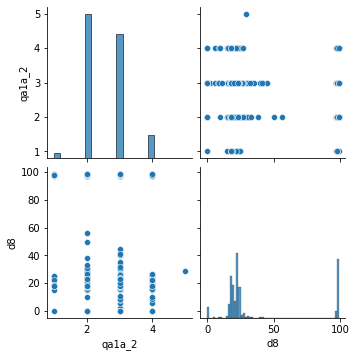

In [50]:
df_1 = df[["isocntry","qa1a_2","d8"]]
df_2 = df_1[df_1['isocntry']=="LT"]
corr_education_econ = df_2["qa1a_2"].corr(df_2["d8"])
print(corr_education_econ)


plt.scatter(df_2["d8"], df_2["qa1a_2"])
df_2.hist("qa1a_2")
sns.pairplot(df_2[['qa1a_2', "d8"]], palette="vlag")


In [5]:
"""Note this is currently unweighted"""
"""This is the old version of the data, since I decide to go for a dictionary approach"""

def fg_counter(counter_value, total_iterations_qty, start, number_of_updates_required_for_total_run = 10, update_counter = False):
    if float(counter_value) % int(total_iterations_qty / number_of_updates_required_for_total_run) == 0:
        print("-----")
        print(datetime.now())
        PC = float(float(counter_value) / total_iterations_qty)
        print(str(counter_value) + " / " + str(total_iterations_qty))
        print(PC)
        print("end estimate @: " + str((datetime.now() - start) * (total_iterations_qty / counter_value) + datetime.now()))
        if update_counter == True:
            return PC    

def transfer_columns(new_df, original_df, target_string, target_string_at_start=True, data_columns_exact_match=False):
    #this method scans every column header of original_df and if target_string is contained within a header, at column is added to new df.
    #this allows me to iterativelly add groups of columns from the original datarame to the reduced datafrom for the analysis
    #target string must be entered as a string
    columns_original = original_df.columns
    columns_new = new_df.columns
    if type(target_string) is str:
        target_string = [target_string]
    
    for string_ in target_string:
        for col in columns_original:
            if col.find(string_) >= 0 and not col in new_df and target_string_at_start==False: #FG_Note: test this additional boolean
                new_df = pd.concat([new_df, original_df[col]], axis=1)
            if col.find(string_) == 0 and not col in new_df and target_string_at_start==True:
                new_df = pd.concat([new_df, original_df[col]], axis=1)
        
    return new_df

def return_stats_on_group(original_df, group_column, group_identifiers, data_group, data_columns_exact_match=False):

    group_flag = []
    group_flag = np.array(original_df[group_column] == group_identifiers[0])

    for i in range(1, len(group_identifiers)):
        group_flag_ = np.array(original_df[group_column] == i)
        group_flag = group_flag or group_flag_
    results_df = original_df[group_flag]
    results_df = results_df.drop(group_column, axis=1) 

    #print(type(float("{:.2f}".format(results_df.values.mean()))))

    return float("{:.2f}".format(results_df.values.mean())), float("{:.2f}".format(results_df.values.std()))

#create data request
unit_request_list = [{"unit_group" : ["GB"], "unit_name": "GB"},
                     {"unit_group" : ["IT"], "unit_name": "Italy"}]
unit_column = "isocntry"
unit_type = "country"
data_request_list = [{"data_group": ["qa1a_"], "data_group_name": "qa1a"},
                     {"data_group": ["qa2a_"], "data_group_name": "qa2a"}]

df_results = pd.DataFrame()
df_reduced = pd.DataFrame()
df_reduced = transfer_columns(df_reduced, df, [unit_column], target_string_at_start=True, data_columns_exact_match=False)    
for data_request in data_request_list:
    df_reduced = transfer_columns(df_reduced, df, data_request["data_group"], target_string_at_start=True, data_columns_exact_match=False)    

for unit_request in unit_request_list:
    result_series_2 = pd.Series()
    for data_request in data_request_list:
        output_mean, output_std = return_stats_on_group(df_reduced, unit_column, unit_request["unit_group"], data_request["data_group"], data_columns_exact_match=False)

        #enter data to series
        result_dict = {(data_request["data_group_name"], "mean"): output_mean, (data_request["data_group_name"], "std"): output_std}
        result_series = pd.Series(result_dict, name=unit_request["unit_name"])
        df_results = df_results.append(result_series)

df_results[unit_type] = df_results.index
df_results = df_results.groupby(unit_type).mean()
df_results

#With the key being: Country, Value Name, Value


qa1a        qa2a      
         mean   std  mean   std
country                        
GB       2.25  0.93  2.25  0.93
Italy    2.65  1.00  2.65  1.00

In [6]:
f = df["isocntry"].values
g = set(f)
print(g)

{'RO', 'MK', 'SI', 'RS-KM', 'BG', 'CY-TCC', 'HR', 'AT', 'LV', 'NL', 'BA', 'SK', 'CH', 'IE', 'GB', 'CZ', 'AL', 'MT', 'DK', 'DE-W', 'SE', 'DE-E', 'CY', 'FR', 'BE', 'EE', 'PT', 'FI', 'LT', 'PL', 'RS', 'IS', 'ME', 'GR', 'NO', 'ES', 'IT', 'TR', 'LU', 'HU'}


In [7]:
#df_results.loc[["qa1a", "mean"]]
#df_results.loc["GB"]["qa1a"]["mean"]

(df_results.index == "GB").any()

True

In [8]:
test_columns = ["qa1a_1", "qa1a_2", "qa1a_3"]
df_test = df.loc[df["isocntry"] == "GB"]

test = df_test[test_columns]

In [9]:
test

,qa1a_1,qa1a_2,qa1a_3
37420,2,3,3
37421,3,3,3
37422,2,3,4
37423,3,3,2
37424,2,3,4
...,...,...,...
38713,2,2,2
38714,3,3,3
38715,2,3,4
38716,3,3,4


In [10]:
#This code is for experimenting with mutli-dimensional python dictionaries

test_dic = {
('A', 'a', "mean"): [1, 2, 3, 4, 5],
('A', 'a', "std"): [1, 2, 3, 4, 5],
('A', 'b', "mean"): [6, 7, 8, 9, 1],
('A', 'b', "std"): [6, 7, 8, 9, 1],
('B', 'a', "mean"): [2, 3, 4, 5, 6],
('B', 'a', "std"): [2, 3, 4, 5, 6],
('B', 'b', "mean"): [7, 8, 9, 1, 2],
('B', 'b', "std"): [7, 8, 9, 1, 2] }



test_dic_insert = {
('a', "mean"): [1, 2, 3, 4, 5],
('a', "std"): [1, 2, 3, 4, 5],
('b', "mean"): [6, 7, 8, 9, 1],
('b', "std"): [6, 7, 8, 9, 1],
}


#def update_key(dict):
#    for entry in dict:

dict_1 = {("group_1", "mean"): 1, ("group_1", "std"): 2,
          ("group_2", "mean"): 2, ("group_2", "std"): 0.5}
test_series_1 = pd.Series(dict_1, name="GB")

dict_2 = {("group_1", "mean"): 3, ("group_1", "std"): 3,
          ("group_2", "mean"): 5, ("group_2", "std"): 8}
test_series_2 = pd.Series(dict_2, name="IT")

pd.DataFrame([test_series_1, test_series_2])




group_1      group_2     
      mean  std    mean  std
GB     1.0  2.0     2.0  0.5
IT     3.0  3.0     5.0  8.0